## Task 2.2 Supervised preprocessing and visualization

In [1]:
import pandas as pd

# Pfad zum CSV
file_path = '../../data/raw/diabetes.csv'

# CSV laden
diabetes_data = pd.read_csv(file_path)

# Vorschau anzeigen
diabetes_data.head()


,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


## IQR-basierte Outlier Detection

Alle Werte außerhalb von [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
werden als Ausreißer markiert.


In [2]:
# Nur numerische Spalten extrahieren
numeric_data = diabetes_data.select_dtypes(include='number')

# IQR
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Grenzen berechnen
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Outlier-Maske: True = Outlier
outliers = (numeric_data < lower_bound) | (numeric_data > upper_bound)

# Zeige Anzahl der Outlier
print("Anzahl erkannter Ausreißer pro numerischer Spalte:")
print(outliers.sum())


Anzahl erkannter Ausreißer pro numerischer Spalte:
preg     4
plas     5
pres    45
skin     1
insu    34
mass    19
pedi    29
age      9
dtype: int64


## Ausreißer durch NaN ersetzen

Ausreißer durch `NaN` ersetzen und entfernen unvollständigen Zeilen mit `dropna()`.  



In [3]:
import numpy as np

# Kopie des Datensatzes
cleaned_data = numeric_data.copy()

# Ersetze Ausreißer mit np.nan
for col in cleaned_data.columns:
    q1 = cleaned_data[col].quantile(0.25)
    q3 = cleaned_data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Ersetze Werte außerhalb der IQR-Grenzen mit NaN
    cleaned_data[col] = cleaned_data[col].mask(
        (cleaned_data[col] < lower) | (cleaned_data[col] > upper),
        np.nan
    )

# Anzahl der NaNs nach dem Ersetzen
print("Fehlende Werte nach Outlier-Entfernung:")
print(cleaned_data.isnull().sum())

# Sicherstellen, dass 'bmi' existiert, bevor wir nach 0 filtern
if 'bmi' in cleaned_data.columns:
    print("\n🔎 Zeilen mit 'bmi' == 0:")
    print(cleaned_data[cleaned_data['bmi'] == 0])
else:
    print("Hinweis: Spalte 'bmi' nicht vorhanden im DataFrame.")

# Entferne alle Zeilen mit fehlenden Werten
cleaned_data = cleaned_data.dropna()

print(f"Verbleibende Zeilen nach Reinigung: {cleaned_data.shape[0]}")



Fehlende Werte nach Outlier-Entfernung:
preg     4
plas     5
pres    45
skin     1
insu    34
mass    19
pedi    29
age      9
dtype: int64
Hinweis: Spalte 'bmi' nicht vorhanden im DataFrame.
Verbleibende Zeilen nach Reinigung: 639


## Chi²-Feature-Ranking

Verwenden von `chi2` aus `sklearn.feature_selection`,  
vorher muss mit `MinMaxScaler` die Werte skaliert werden.


In [4]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Zielvariable definieren
y = diabetes_data.loc[cleaned_data.index, 'class'] 

# Daten normalisieren
X_scaled = MinMaxScaler().fit_transform(cleaned_data)

# Chi²-Test
chi2_scores, p_values = chi2(X_scaled, y)

# Ergebnis
chi2_df = pd.DataFrame({
    'Feature': cleaned_data.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
}).sort_values(by='Chi2 Score', ascending=False)

# Ausgabe
print("Chi²-Feature-Ranking:")
print(chi2_df)


Chi²-Feature-Ranking:
  Feature  Chi2 Score   p-value
1    plas   11.388388  0.000739
7     age   10.304719  0.001327
0    preg    7.130373  0.007579
5    mass    4.365088  0.036683
6    pedi    3.296525  0.069427
4    insu    1.840731  0.174865
2    pres    1.189877  0.275354
3    skin    0.114502  0.735076


## Boxplots und Verteilungen der Features

Chi²-Wert mithilfe von `seaborn.boxplot()` und `seaborn.histplot()`.


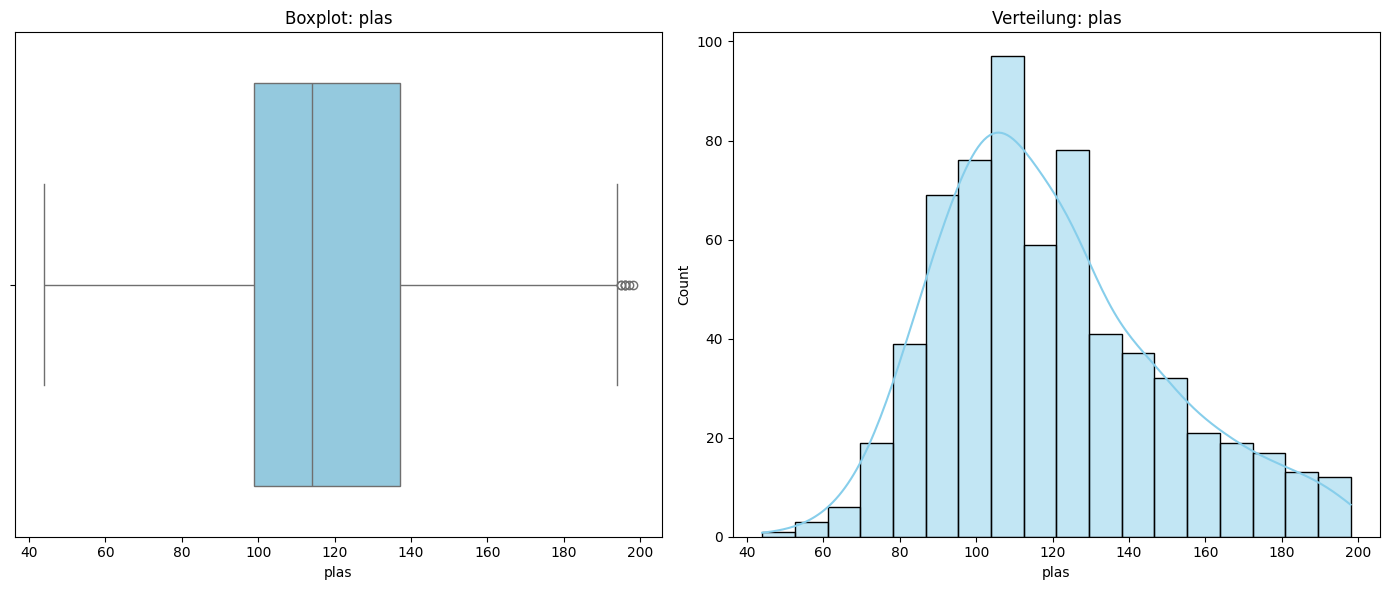

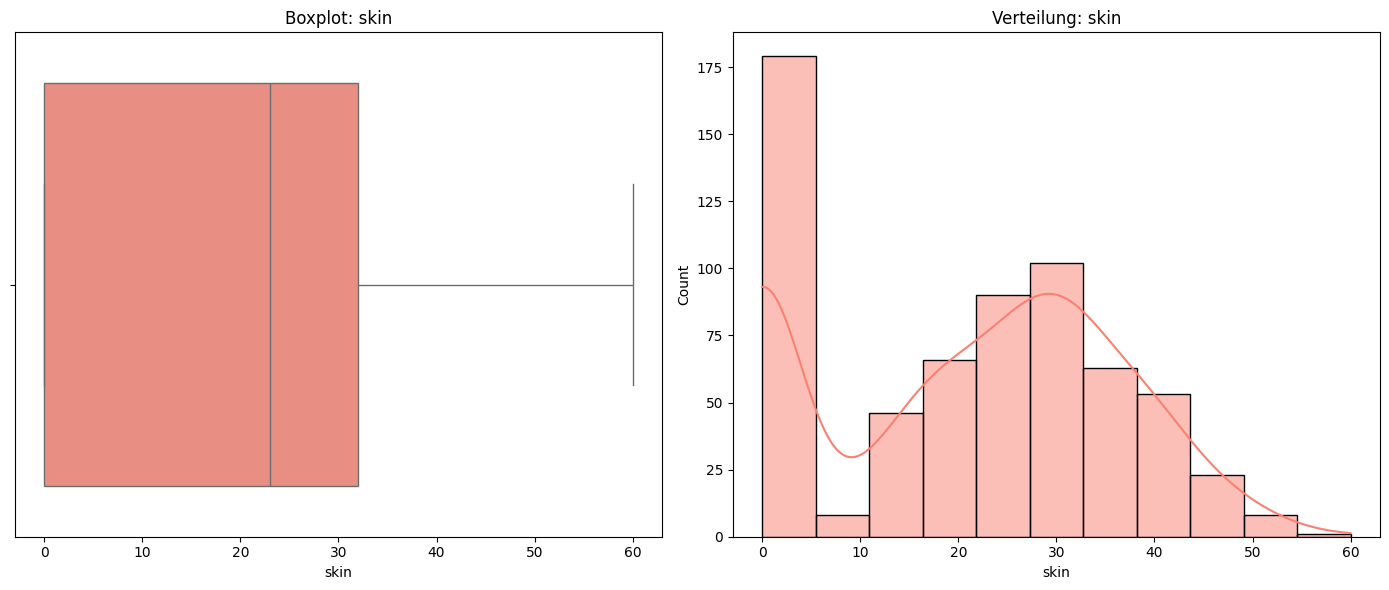

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Feature aus dem Ranking
top_feature = chi2_df.iloc[0]['Feature']
low_feature = chi2_df.iloc[-1]['Feature']

# Plot
plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=cleaned_data[top_feature], color='skyblue')
plt.title(f"Boxplot: {top_feature}")

# Histoplot
plt.subplot(1, 2, 2)
sns.histplot(cleaned_data[top_feature], kde=True, color='skyblue')
plt.title(f"Verteilung: {top_feature}")

plt.tight_layout()
plt.show()

# Feature 1
plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=cleaned_data[low_feature], color='salmon')
plt.title(f"Boxplot: {low_feature}")

# Histoplot
plt.subplot(1, 2, 2)
sns.histplot(cleaned_data[low_feature], kde=True, color='salmon')
plt.title(f"Verteilung: {low_feature}")

plt.tight_layout()
plt.show()
